**Mounting drive** connecting to have access to our database

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Required for the code

In [ ]:
#!pip install light-the-torch >> /.tmp
#!ltt install torch torchvision >> /.tmp
#!pip install fastai --upgrade >> /.tmp

Uncomment the following lines if GPU doesn't seem to be working, may be your version of tensorflow is not prepared to work with GPU

In [ ]:
#!chronic pip install tensorflow-gpu==2.0.0
#!pip uninstall tensorflow

In [ ]:
#testing if there is a GPU or not. if you don't get "Found GPU at: /device:GPU:0" then you have to activate your GPU before starting the work 
# to activate the gpu : select "Runtime" in the google colab's toolbar then "change runtime type" then choose "GPU" and save changes
%tensorflow_version 2.x
import tensorflow as tf
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


**Import the required libraries**

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
import keras
from keras.models import Sequential
from keras.layers import Dense, Conv2D , MaxPool2D , Flatten , Dropout 
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import classification_report,confusion_matrix
import cv2
import os
import numpy as np

**Loading the data** 

In [ ]:
labels = ['NORMAL', 'PNEUMONIA'] #Labeling data
#Without having a fixed input shape, you cannot define architecture of your model. It is therefore necessary to convert all your images to same size.
img_size =224
def get_data(data_dir):
    data = [] 
    for label in labels: 
        path = os.path.join(data_dir, label)
        class_num = labels.index(label)
        for img in os.listdir(path):
            try:
                img_arr = cv2.imread(os.path.join(path, img))[...,::-1] #convert BGR to RGB format
                resized_arr = cv2.resize(img_arr, (img_size, img_size)) # Reshaping images to preferred size ( the '-1' reverse the order of colors channels )
                data.append([resized_arr, class_num])
            except Exception as e:
                print(e)
    return np.array(data) # numpy makes it easier to manipulate image data and takes less amount of memory compared to python's lists



> *specifiying data path*



In [ ]:
with tf.device('/device:GPU:0'):# ensure you are working with your GPU 
#loading the validation and training data 
  train = get_data('/content/drive/MyDrive/Kaggle/pneumonia_data/chest_xray/chest_xray/train')
  val = get_data('/content/drive/MyDrive/Kaggle/pneumonia_data/chest_xray/chest_xray/val')

'NoneType' object is not subscriptable


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:15: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  from ipykernel import kernelapp as app


'NoneType' object is not subscriptable
'NoneType' object is not subscriptable


**Visualizing Data**

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


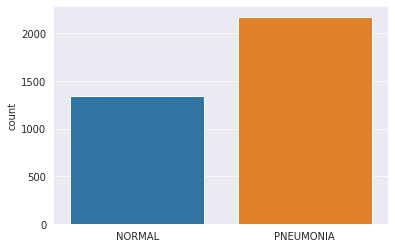

In [ ]:
l = []
for i in train:
    if(i[1] == 0):
        l.append("NORMAL")
    else:
        l.append("PNEUMONIA")
sns.set_style('darkgrid')
sns.countplot(l)
# visualizing data is an important step: although it's preferred to have equal size of data for each class , it's understandable to have more images 
# for different forms of this anomaly 

Text(0.5, 1.0, 'NORMAL')

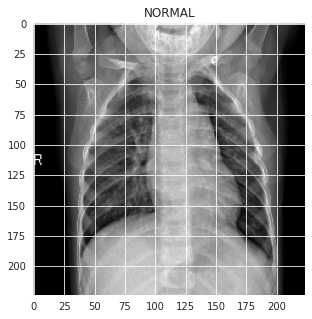

In [ ]:
#example of the data ( ensure that images are quite visible and detectable, even if they are smaller then first, to make the model work effeciently )
plt.figure(figsize = (5,5))
plt.imshow(train[1][0])
plt.title(labels[train[0][1]])

Text(0.5, 1.0, 'PNEUMONIA')

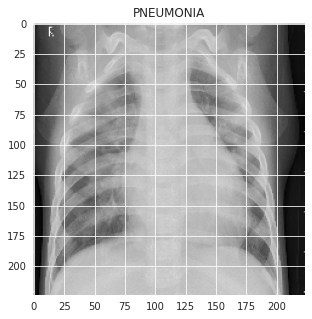

In [ ]:
#example2
plt.figure(figsize = (5,5))
plt.imshow(train[-1][0])
plt.title(labels[train[-1][1]])

**Data preprocessing**

In [ ]:
#x and y represents two lists of each dataset ( training or validation , x_train/x_val is a list of images and y_train/y_val is a list of the corresponding label)
x_train = []
y_train = []
x_val = []
y_val = []

for feature, label in train:
  x_train.append(feature)
  y_train.append(label)

for feature, label in val:
  x_val.append(feature)
  y_val.append(label)

# Normalize the data : all pixel values (between 0 and 255) will be values from 0 to 1 to make the work easier
x_train = np.array(x_train) / 255 
x_val = np.array(x_val) / 255
#changing the order of parameters to reverse the order of channels colors -> working with numpy arrays 
x_train.reshape(-1, img_size, img_size, 1)
y_train = np.array(y_train)

x_val.reshape(-1, img_size, img_size, 1)
y_val = np.array(y_val)

**Data augmentation** 

> Data augmentation is a set of techniques to artificially increase the amount of data by generating new data points from existing data. This includes making small changes to data or using deep learning models to generate new data points.

> for images's datasets it can be done by zooming images/ increasing brightness/ rotating the image in different directions / whitening 





In [ ]:
def gpu_datagen():
  with tf.device('/device:GPU:0'):
    datagen = tf.keras.preprocessing.image.ImageDataGenerator(
            featurewise_center=False,  # set input mean to 0 over the dataset
            samplewise_center=False,  # set each sample mean to 0
            featurewise_std_normalization=False,  # divide inputs by std of the dataset
            samplewise_std_normalization=False,  # divide each input by its std
            zca_whitening=False,  # apply ZCA whitening
            rotation_range = 30,  # randomly rotate images in the range (degrees, 0 to 180)
            zoom_range = 0.2, # Randomly zoom image 
            width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
            height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
            horizontal_flip = True,  # randomly flip images
            vertical_flip=False)  # randomly flip images
    return datagen.fit(x_train)

In [ ]:
gpu_datagen()

***Define the Model***

Let’s define a simple CNN model with 3 Convolutional layers followed by max-pooling layers. A dropout layer is added after the 3rd maxpool operation to avoid overfitting.
---
**Overfitting** is "the production of an analysis that corresponds too closely or exactly to a particular set of data, and may therefore fail to fit to additional data or predict future observations reliably".

**MaxPooling for 2D spatial data** Downsamples the input along its spatial dimensions (height and width) by taking the maximum value over an input window (of size defined by pool_size ) for each channel of the input.

**Dropout layer** The Dropout layer is a mask that nullifies the contribution of some neurons towards the next layer and leaves unmodified all others.Usually, dropout is placed on the fully connected layers only because they are the one with the greater number of parameters and thus they're likely to excessively co-adapting themselves causing overfitting.

**Conv2D layer** creates a convolution kernel that is convolved with the layer input to produce a tensor of outputs.

**Flatten layer**  A flatten layer collapses the spatial dimensions of the input into the channel dimension. For example, if the input to the layer is an H-by-W-by-C-by-N-by-S array (sequences of images), then the flattened output is an (H*W*C)-by-N-by-S array -> you want to make it linear to pass it onto a Dense layer

**Dense layer** The dense layer is a neural network layer that is connected deeply, which means each neuron in the dense layer receives input from all neurons of its previous layer. The dense layer is found to be the most commonly used layer in the models. visit : https://machinelearningknowledge.ai/keras-dense-layer-explained-for-beginners/

In [ ]:
model = Sequential()
model.add(Conv2D(32,3,padding="same", activation="relu", input_shape=(224,224,3)))
model.add(MaxPool2D())

model.add(Conv2D(32, 3, padding="same", activation="relu"))
model.add(MaxPool2D())

model.add(Conv2D(64, 3, padding="same", activation="relu"))
model.add(MaxPool2D())
model.add(Dropout(0.4))

model.add(Flatten())
model.add(Dense(128,activation="relu"))
model.add(Dense(2, activation="softmax"))

model.summary()
# after training the model you can add layers or change their hyperparameters to make your predictions better if you are not satisfied with the accuracy

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 224, 224, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 112, 112, 32)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 112, 112, 32)      9248      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 56, 56, 32)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 56, 56, 64)        18496     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 28, 28, 64)       0

Optimization function : Gradient Descendent

In [ ]:
#we will be using the gradient descendent function (Adam in python) with a learning rate of lr=0.000001
opt = Adam(lr=0.000001)
model.compile(optimizer = opt , loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True) , metrics = ['accuracy'])

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


**fitting the model : training**

In [ ]:
from tensorflow.keras import Model
with tf.device('/device:GPU:0'):#ensure you are working with GPU !! 
  history = model.fit(x_train,y_train,epochs = 500 , validation_data = (x_val, y_val)) #choosing a large number of epochs because learning rate is too small 
  #you can change the hyperparameters to obtain better results

Epoch 1/500


/usr/local/lib/python3.7/dist-packages/tensorflow/python/util/dispatch.py:1082: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  return dispatch_target(*args, **kwargs)


110/110 [==============================] - 18s 50ms/step - loss: 0.6662 - accuracy: 0.6186 - val_loss: 0.7041 - val_accuracy: 0.5000
Epoch 2/500
110/110 [==============================] - 5s 43ms/step - loss: 0.6498 - accuracy: 0.6186 - val_loss: 0.6938 - val_accuracy: 0.5000
Epoch 3/500
110/110 [==============================] - 5s 43ms/step - loss: 0.6327 - accuracy: 0.6197 - val_loss: 0.6843 - val_accuracy: 0.5000
Epoch 4/500
110/110 [==============================] - 5s 43ms/step - loss: 0.6056 - accuracy: 0.6368 - val_loss: 0.6577 - val_accuracy: 0.5625
Epoch 5/500
110/110 [==============================] - 5s 43ms/step - loss: 0.5812 - accuracy: 0.6968 - val_loss: 0.6455 - val_accuracy: 0.5625
Epoch 6/500
110/110 [==============================] - 5s 45ms/step - loss: 0.5503 - accuracy: 0.7412 - val_loss: 0.6171 - val_accuracy: 0.6250
Epoch 7/500
110/110 [==============================] - 5s 44ms/step - loss: 0.5194 - accuracy: 0.8083 - val_loss: 0.6191 - val_accuracy: 0.6250
Epo

As we can see from the results above : values of accuracy ( 0.98->98% ) and loss (0.03-> 3%) are satisfying so no need to retrain the model with other hyperparameters

In [ ]:
model.save("/content/drive/MyDrive/model")
#the model will be saved in the specified path as a .SavedModel file : it's a folder which have two folders( assets, variables) and .pb files 

INFO:tensorflow:Assets written to: /content/drive/MyDrive/model/assets


**Evaluating results**

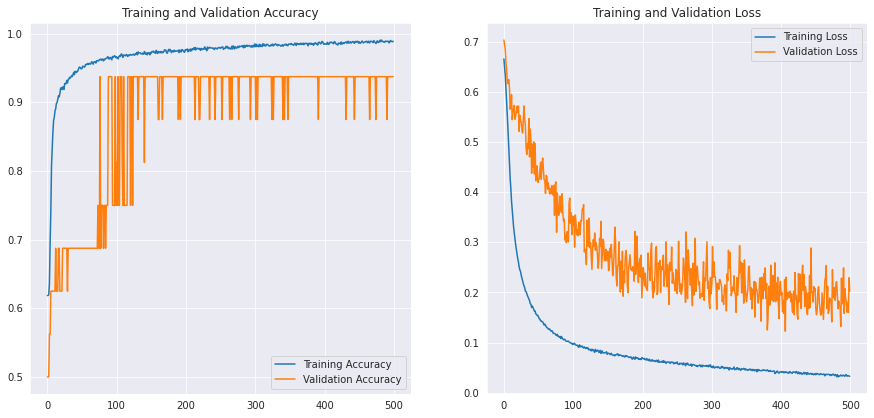

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(500)

plt.figure(figsize=(15, 15))
plt.subplot(2, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

**Testing the model**
---


In [ ]:
test_dataset=get_data('/content/drive/MyDrive/Kaggle/pneumonia_data/chest_xray/chest_xray/test')

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:15: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  from ipykernel import kernelapp as app


In [ ]:
from torchvision.datasets import ImageFolder
from torchvision.transforms import ToTensor
import torch
import torchvision
from torch import *
dataset = ImageFolder('/content/drive/MyDrive/Kaggle/pneumonia_data/chest_xray/chest_xray/train', transform=ToTensor()) 
test_dataset = ImageFolder('/content/drive/MyDrive/Kaggle/pneumonia_data/chest_xray/chest_xray/test', transform=ToTensor())

In [ ]:

from keras.models import load_model
model=load_model("/content/drive/MyDrive/model")
predictions = model.predict(x_val)
predictions = predictions.reshape(1,-1)[0]
prediction = np.where(y_val > 0.5, 1, 0) #y_val values are 0 or 1 ( binary ) and we need to compare them 
print(classification_report(y_val, (prediction[0:16]), target_names = ['NORMAL','PNEUMONIA']))

              precision    recall  f1-score   support

      NORMAL       1.00      1.00      1.00         8
   PNEUMONIA       1.00      1.00      1.00         8

    accuracy                           1.00        16
   macro avg       1.00      1.00      1.00        16
weighted avg       1.00      1.00      1.00        16

